In [1]:
import sys
print(sys.version)


2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


In [12]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing, tree, model_selection,svm
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc
from scipy import interp
from ggplot import *

In [3]:
spam_data = pd.read_csv("C:/Users/venka/Documents/Fall Semester/Predictive Analytics/Assignment 4/spambasedata.csv",header=None)
spam_data=spam_data.as_matrix()

predictors=spam_data[:,:57]
target=spam_data[:,57]

min_max_scaler = preprocessing.MinMaxScaler()
predictors_norm = min_max_scaler.fit_transform(predictors)



In [4]:
# pre processing
# model=SVR(kernel="linear")
# model=LogisticRegression()
# selector = RFECV(model, step=1, cv=5)
# fitted = selector.fit(predictors, target)
# predictors_model = SelectFromModel(selector, prefit=True)
# predictors_new=predictors_model.transform(predictors)

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(predictors_norm, target)
model = SelectFromModel(lsvc, prefit=True)
predictors_new_v1 = model.transform(predictors_norm)

# print predictors_new.shape
# print predictors_new[:5,:]
# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
#   ('classification', RandomForestClassifier())
# ])
# clf.fit(X, y)
print 'The model is {}'.format(model)


The model is SelectFromModel(estimator=LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        prefit=True, threshold=None)


In [5]:
clf = ExtraTreesClassifier()
clf = clf.fit(predictors_norm, target)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
predictors_new = model.transform(predictors_norm)
print predictors_new.shape

(4601L, 18L)


In [6]:
cost_matrix=np.matrix([[0, 10], [1, 0]])

In [46]:
#k-NN (Feature selection - Linear SVC)
k_best=0
miscal_previous_knn=100000
min_k=5
max_k=45
step=2
miscal_knn = []
neighbors_range=range(min_k,max_k,step)

for n_neighbors in neighbors_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors,weights='distance',metric='manhattan')
    predicted_knn = cross_val_predict (knn, predictors_new, target, cv=10)
    
    cm_knn=confusion_matrix(target,predicted_knn)
    profit_matrix_knn = np.multiply(cm_knn, cost_matrix)
    miscal_cost_knn = (profit_matrix_knn.item(1) + profit_matrix_knn.item(2))*1.00/4601
    miscal_knn.append(miscal_cost_knn)
        
    if miscal_cost_knn<miscal_previous_knn:
        precision_knn = metrics.precision_score(target,predicted_knn)
        recall_knn = metrics.recall_score(target,predicted_knn)
        accuracy_knn=metrics.accuracy_score(target, predicted_knn)*100
        f_knn= metrics.f1_score(target,predicted_knn)
        k_best=n_neighbors
        miscal_previous_knn=miscal_cost_knn
        cm_knn_best=cm_knn

knn_best = neighbors.KNeighborsClassifier(k_best,weights='distance',metric='manhattan')
pred_prob_knn= cross_val_predict (knn_best, predictors_new, target, cv=10, method='predict_proba')
auc_knn= metrics.roc_auc_score(target,pred_prob_knn[:,1])

In [21]:
print 'The best K-value: {}'.format(k_best)
print 'Accuracy: {:.2f}%' .format(accuracy_knn)
print 'Precision: {:.2f}%'.format(precision_knn*100)
print 'Recall: {:.2f}%'.format(recall_knn*100)
print 'F measure: {:.2f}'.format(f_knn)
print 'AUC: {:.2f}'.format(auc_knn)
print 'Average Misclassification cost: ${:.2f}' .format(miscal_previous_knn*1.00000/4601)
print 'The confusion matrix is \n{}'.format(cm_knn_best)

The best K-value: 37
Accuracy: 89.96%
Precision: 95.98%
Recall: 77.77%
F measure: 0.86
AUC: 0.96
Average Misclassification cost: $0.22
The confusion matrix is 
[[2729   59]
 [ 403 1410]]


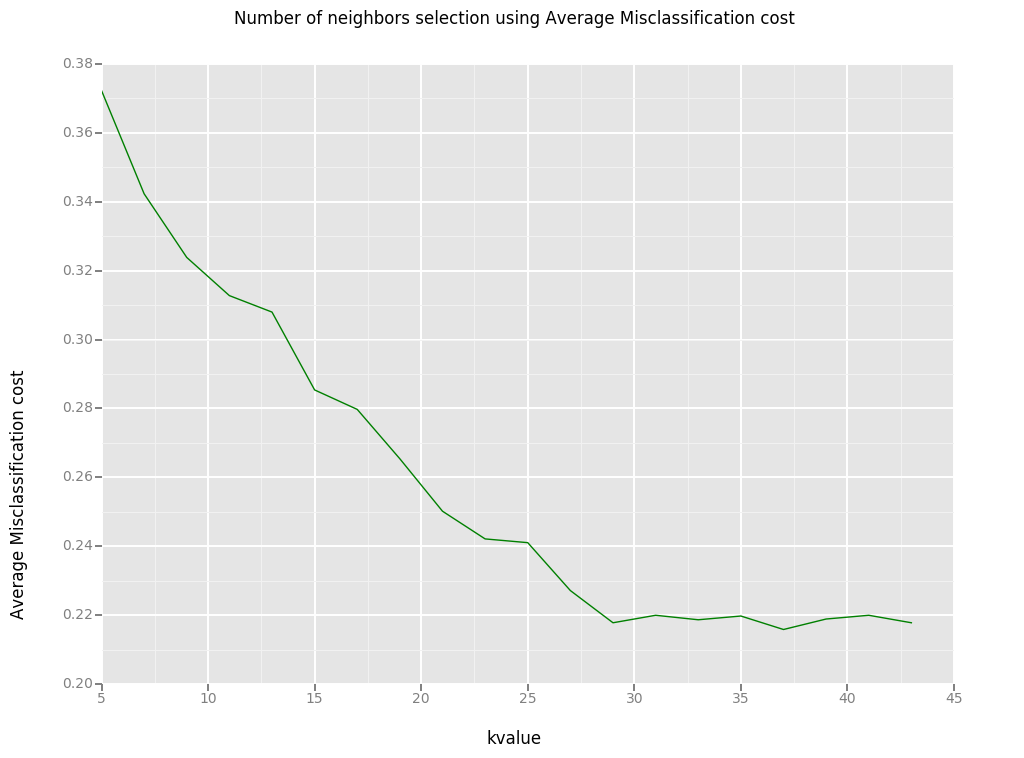

<ggplot: (19164090)>

In [47]:

accuracy_knn_df=pd.DataFrame(miscal_knn)
accuracy_knn_df.columns=['Average Misclassification cost']
accuracy_knn_df['kvalue']=neighbors_range
ggplot(accuracy_knn_df, aes(x='kvalue',y='Average Misclassification cost')) + geom_line(color='green') +ggtitle('Number of neighbors selection using Average Misclassification cost')

# miscal_knn_df=pd.DataFrame(miscal_knn)
# miscal_knn_df.index=neighbors_range
# plt.plot(miscal_knn_df)
# plt.xlabel("k value")
# plt.ylabel("Misclassification cost")
# plt.title('Number of neighbors selection using miscalssification cost')
# plt.show()

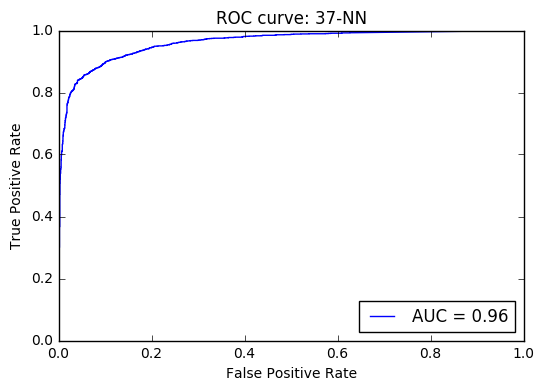

In [19]:
#ROC curve (For selected k)
fpr, tpr, thresholds = roc_curve(target, pred_prob_knn[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_knn))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: {}-NN'.format(k_best))
plt.legend(loc="lower right")
plt.show()

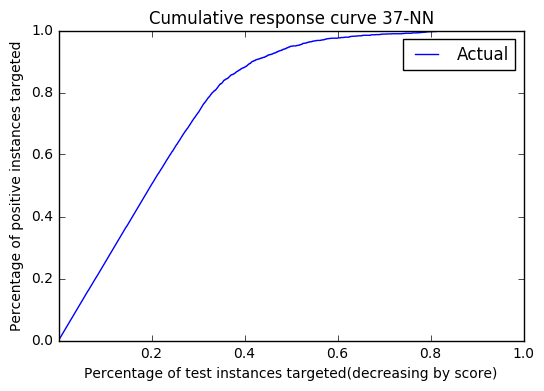

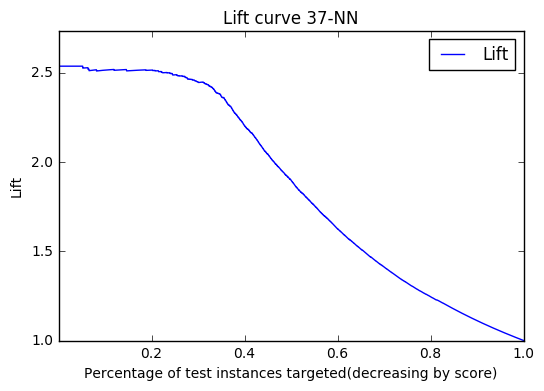

In [20]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_knn[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve {}-NN'.format(k_best))

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve {}-NN'.format(k_best))

In [49]:
#Decision tree
complexity_values = range(1,15)
miscal_previous_dtree=100000
miscal_dtree = []

for complexity_value in complexity_values:
    dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=complexity_value)
    predicted_dtree = cross_val_predict (dtree, predictors_new, target, cv=10)
    
    cm_dtree=confusion_matrix(target,predicted_dtree)
    profit_matrix_dtree = np.multiply(cm_dtree, cost_matrix)
    miscal_cost_dtree = (profit_matrix_dtree.item(1) + profit_matrix_dtree.item(2))*1.00/4601
    miscal_dtree.append(miscal_cost_dtree)
    
    if miscal_cost_dtree<miscal_previous_dtree:
        accuracy_dtree=metrics.accuracy_score(target, predicted_dtree)*100
        precision_dtree = metrics.precision_score(target,predicted_dtree)
        recall_dtree = metrics.recall_score(target,predicted_dtree)
        f_dtree= metrics.f1_score(target,predicted_dtree)
        miscal_previous_dtree=miscal_cost_dtree
        depth_best=complexity_value
        cm_dtree_best=cm_dtree
        
dtree_best = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth_best)
pred_prob_dtree= cross_val_predict (dtree_best, predictors_new, target, cv=10, method='predict_proba')
auc_dtree= metrics.roc_auc_score(target,pred_prob_dtree[:,1])
print 'The optimal depth: {}'.format(depth_best)
print 'Accuracy: {:.2f}%' .format(accuracy_dtree)
print 'Precision: {:.2f}%'.format(precision_dtree*100)
print 'Recall: {:.2f}%'.format(recall_dtree*100)
print 'F measure: {:.2f}'.format(f_dtree)
print 'AUC: {:.2f}'.format(auc_dtree)
print 'Average misclassification cost: ${:.2f}' .format(miscal_previous_dtree/4601)
print 'The confusion matrix is \n{}'.format(cm_dtree_best)

    
miscal_dtree_df=pd.DataFrame(miscal_dtree)
miscal_dtree_df.index=complexity_values
depth_best=miscal_dtree_df.idxmin()

The optimal depth: 8
Accuracy: 92.07%
Precision: 92.84%
Recall: 86.54%
F measure: 0.90
AUC: 0.95
Average misclassification cost: $0.32
The confusion matrix is 
[[2667  121]
 [ 244 1569]]


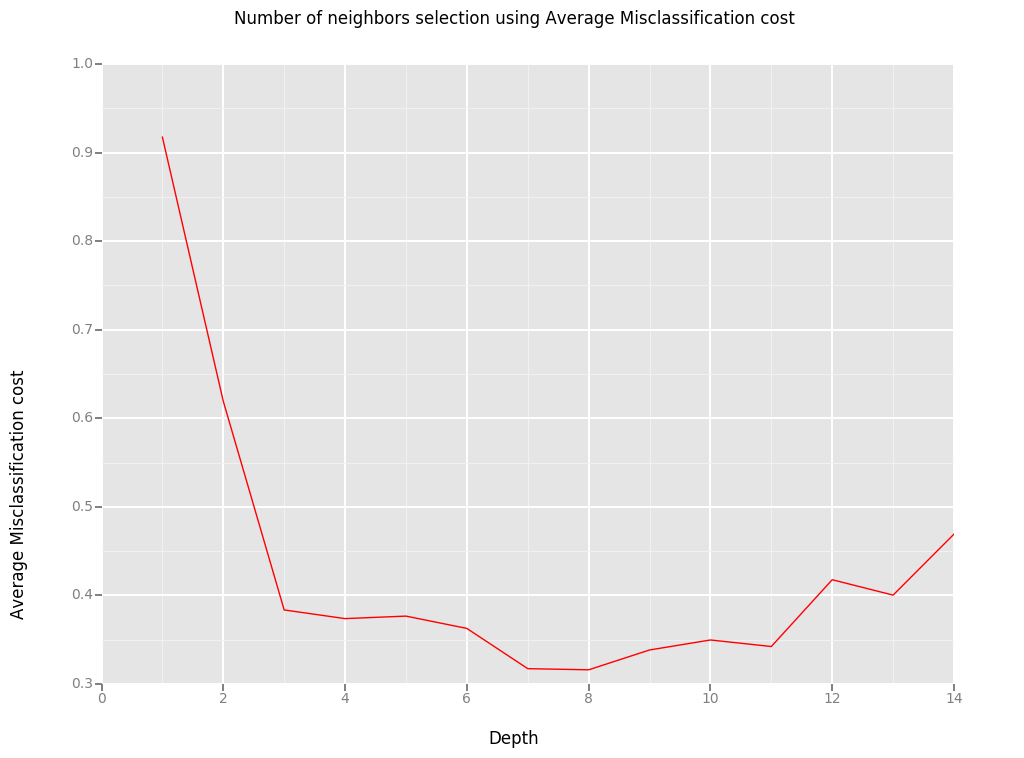

<ggplot: (18763577)>

In [50]:
accuracy_dtree_df=pd.DataFrame(miscal_dtree)
accuracy_dtree_df.columns=['Average Misclassification cost']
accuracy_dtree_df['Depth']=complexity_values
ggplot(accuracy_dtree_df, aes(x='Depth',y='Average Misclassification cost')) + geom_line(color='red') +ggtitle('Number of neighbors selection using Average Misclassification cost')

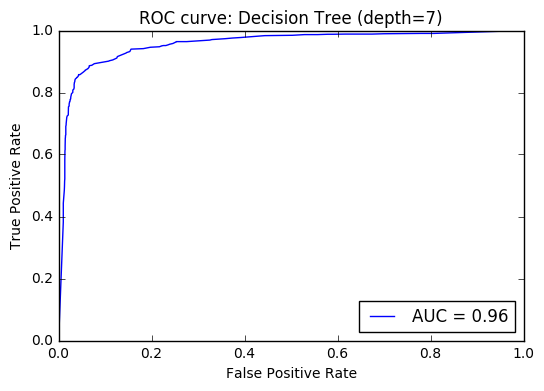

In [27]:
#ROC curve (Decision tree)
fpr, tpr, thresholds = roc_curve(target, pred_prob_dtree[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_dtree))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Decision Tree (depth={})'.format(depth_best[0]))
plt.legend(loc="lower right")
plt.show()

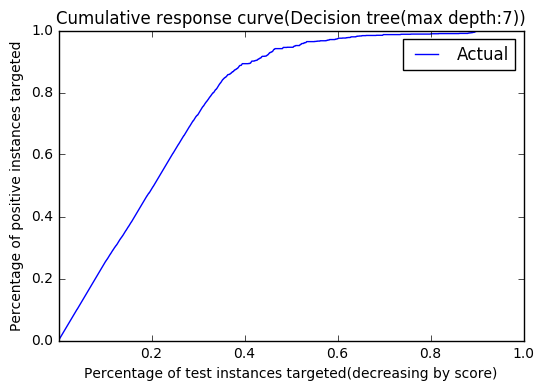

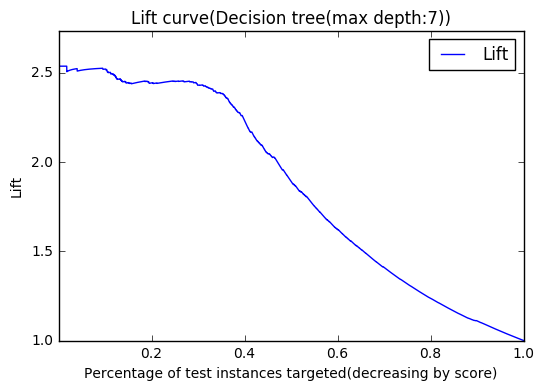

In [29]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_dtree[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve(Decision tree(max depth:{}))'.format(depth_best[0]))

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve(Decision tree(max depth:{}))'.format(depth_best[0]))

In [32]:
lr = LogisticRegression(C=1e5)
predicted_lr = cross_val_predict (lr, predictors_new, target, cv=10)
    
pred_prob_lr= cross_val_predict (lr, predictors_new, target, cv=10, method='predict_proba')
cm_lr=confusion_matrix(target,predicted_lr)
profit_matrix_lr = np.multiply(cm_lr, cost_matrix)
miscal_cost_lr = profit_matrix_lr.item(1) + profit_matrix_lr.item(2)
precision_lr = metrics.precision_score(target,predicted_lr)
recall_lr = metrics.recall_score(target,predicted_lr)
f_lr= metrics.f1_score(target,predicted_lr)
auc_lr= metrics.roc_auc_score(target,pred_prob_lr[:,1])
    
print 'Accuracy: {:.2f}%' .format(metrics.accuracy_score(target, predicted_lr)*100)
print 'Precision: {:.2f}%'.format(precision_lr*100)
print 'Recall: {:.2f}%'.format(recall_lr*100)
print 'F measure: {:.2f}'.format(f_lr)
print 'AUC: {:.2f}'.format(auc_lr)
print 'Average Misclassification cost: ${:.2f}' .format(miscal_cost_lr*1.00/4601) 
print 'The confusion matrix is \n{}'.format(cm_lr)

Accuracy: 90.74%
Precision: 90.96%
Recall: 84.94%
F measure: 0.88
AUC: 0.96
Average Misclassification cost: $0.39
The confusion matrix is 
[[2635  153]
 [ 273 1540]]


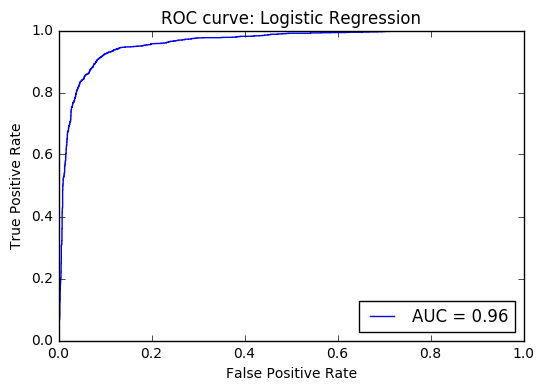

In [33]:
#ROC curve
fpr, tpr, thresholds = roc_curve(target, pred_prob_lr[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_lr))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Logistic Regression')
plt.legend(loc="lower right")
plt.show()

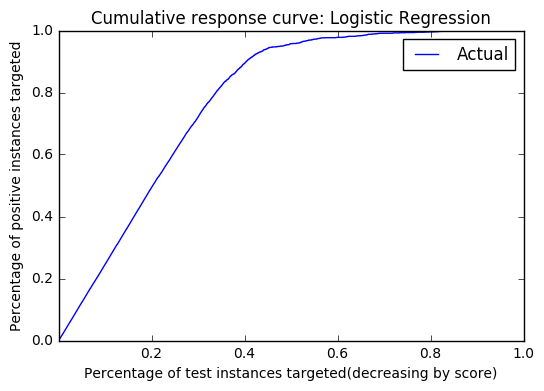

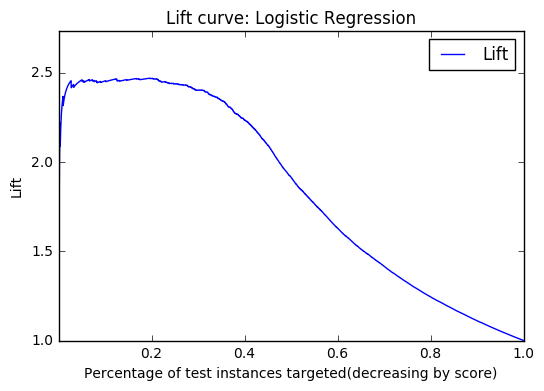

In [34]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_lr[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Logistic Regression')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Logistic Regression')

In [37]:
miscal_previous_svc=100000000
count=0
kernels=['linear', 'rbf', 'sigmoid']
miscal_svc = []

for kernel in kernels:
    svc = SVC(C=10.0, kernel=kernel)
    svc_prob = SVC(C=10.0, probability=True,kernel=kernel)
    predicted_svc = cross_val_predict(svc, predictors_new, target, cv=10)
    cm_svc=confusion_matrix(target,predicted_svc)
    profit_matrix_svc = np.multiply(cm_svc, cost_matrix)
    miscal_cost_svc = profit_matrix_svc.item(1) + profit_matrix_svc.item(2)
    miscal_svc.append(miscal_cost_svc)

    if miscal_cost_svc<miscal_previous_svc:
        precision_svc = metrics.precision_score(target,predicted_svc)
        recall_svc = metrics.recall_score(target,predicted_svc)
        f_svc = metrics.f1_score(target,predicted_svc)
        accuracy_svc=metrics.accuracy_score(target, predicted_svc)*100
        miscal_previous_svc=miscal_cost_svc
        kernel_best=kernel
        cm_svc_best=cm_svc

svc_prob = SVC(C=1.0, probability=True,kernel=kernel_best)
pred_prob_svc = cross_val_predict(svc_prob, predictors_new, target, cv=10, method='predict_proba')
auc_svc = metrics.roc_auc_score(target,pred_prob_svc[:,1])

In [38]:
print 'Accuracy: {:.2f}%' .format(accuracy_svc)
print 'Precision: {:.2f}%'.format(precision_svc*100)
print 'Recall: {:.2f}%'.format(recall_svc*100)
print 'F measure: {:.2f}'.format(f_svc)
print 'AUC: {:.2f}'.format(auc_svc)
print 'Misclassification cost: ${:.2f}' .format(miscal_previous_svc*1.00/4601) 
print 'The best kernel for SVC is {}' .format(kernel_best)
print 'The confusion matrix is \n{}'.format(cm_svc_best)

# miscal_svc_df=pd.DataFrame(miscal_svc)
# miscal_svc_df.index=kernels
# plt.plot(miscal_svc_df)
# plt.xlabel("Kernel")
# plt.ylabel("Misclassification cost")
# plt.title('Kernel selection using miscalssification cost')
# plt.show()

Accuracy: 87.29%
Precision: 91.21%
Recall: 74.96%
F measure: 0.82
AUC: 0.91
Misclassification cost: $0.38
The best kernel for SVC is rbf
The confusion matrix is 
[[2657  131]
 [ 454 1359]]


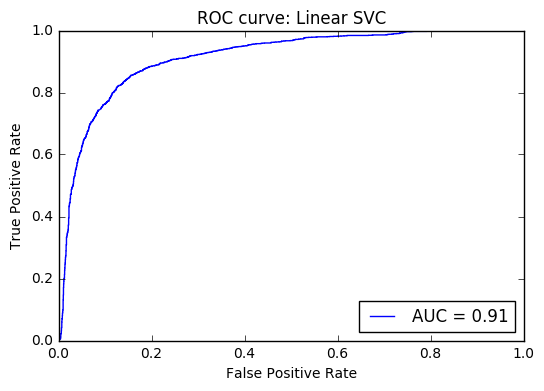

In [39]:
#ROC curve
#ROC curve (For selected k)
fpr, tpr, thresholds = roc_curve(target, pred_prob_svc[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_svc))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Linear SVC')
plt.legend(loc="lower right")
plt.show()

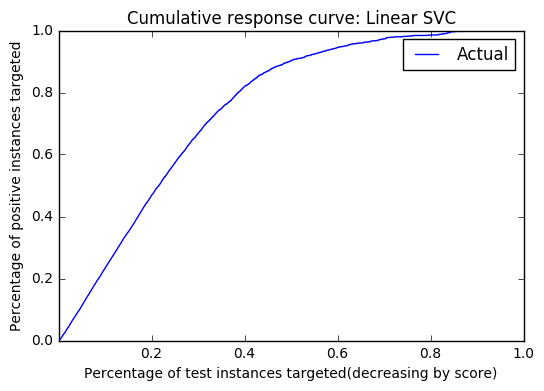

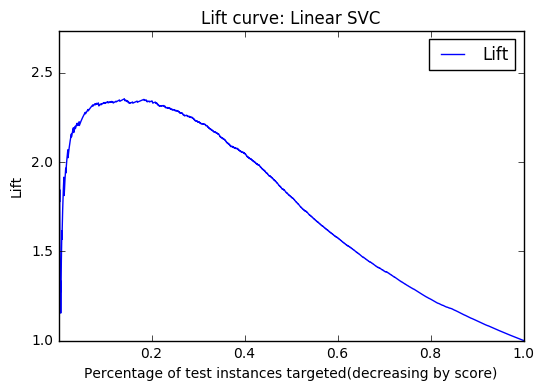

In [40]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_svc[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Linear SVC')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.00/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Linear SVC')

In [43]:
nb = GaussianNB()
predicted_nb = cross_val_predict (nb, predictors_new, target, cv=10)
    
pred_prob_nb= cross_val_predict (nb, predictors_new, target, cv=10, method='predict_proba')
cm_nb=confusion_matrix(target,predicted_nb)
profit_matrix_nb = np.multiply(cm_nb, cost_matrix)
miscal_cost_nb = profit_matrix_nb.item(1) + profit_matrix_nb.item(2)
precision_nb = metrics.precision_score(target,predicted_nb)
recall_nb = metrics.recall_score(target,predicted_nb)
f_nb= metrics.f1_score(target,predicted_nb)
auc_nb= metrics.roc_auc_score(target,pred_prob_nb[:,1])
    
print 'Accuracy: {:.2f}%' .format(metrics.accuracy_score(target, predicted_nb)*100)
print 'Precision: {:.2f}%'.format(precision_nb*100)
print 'Recall: {:.2f}%'.format(recall_nb*100)
print 'F measure: {:.2f}'.format(f_nb)
print 'AUC: {:.2f}'.format(auc_nb)
print 'Average Misclassification cost: ${:.2f}' .format(miscal_cost_nb*1.00/4601) 
print 'The confusion matrix is \n{}'.format(cm_nb)

Accuracy: 88.20%
Precision: 89.99%
Recall: 78.82%
F measure: 0.84
AUC: 0.95
Average Misclassification cost: $0.43
The confusion matrix is 
[[2629  159]
 [ 384 1429]]


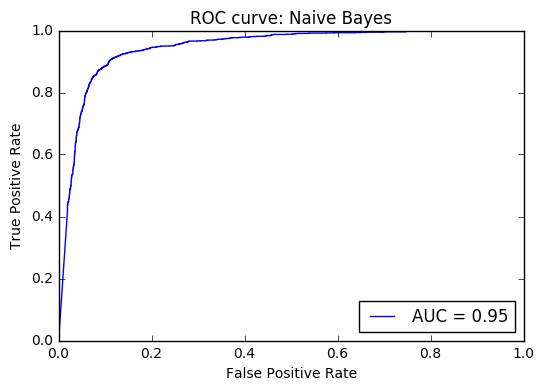

In [44]:
#ROC curve
fpr, tpr, thresholds = roc_curve(target, pred_prob_nb[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_nb))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Naive Bayes')
plt.legend(loc="lower right")
plt.show()

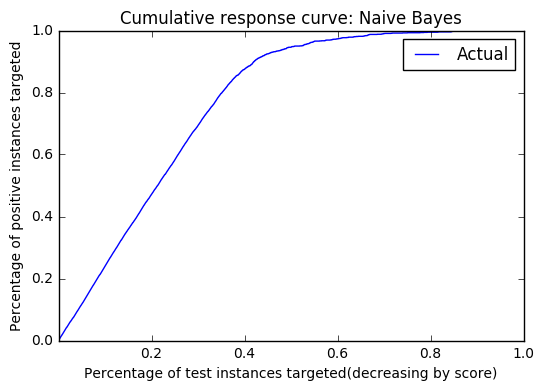

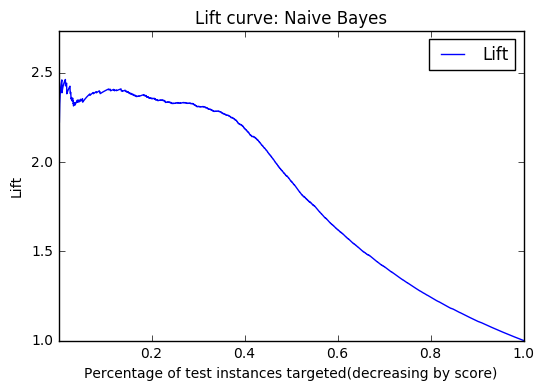

In [45]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_nb[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Naive Bayes')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.00/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Naive Bayes')